In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
############################################################
'''
Part 1: RK4 Validation with simple spring-damper model + PID control
'''
############################################################

## parameter setup
# Integration parameter 
h=1/100  # step size    (sec)
t0=0    # initial time (sec)
tf=10    # final time (sec)


time=np.linspace(t0,tf,int((tf-t0)/h))

## motion initial state
x_t0=1.0
v_t0=0
a_t0=0

x_target=3.0         # height target [m]

motion_t0=np.array([x_t0,v_t0])
motion_t=np.zeros((len(motion_t0),len(time)))


## PID parameters
kp=0.5
ki=1.0
kd=1.5

integral=0   # initialize the integral
lasterr=0    # for the kd  

In [3]:
# Butcher Array
RK4matrix=np.array([
      [0,0,0,0],
      [1/4,1/4,0,0],
      [27/40,-189/800,729/800,0],       
      [1,214/891,1/33,650/891],       
      [214/891,1/33,650/891,0],      
   ])


def rk4_ex(f,t,x,h,*args):  #*args allows unknown number of arguments
   k1=f(t+h*RK4matrix[0][0],x+h*RK4matrix[0][1],*args)
   k2=f(t+h*RK4matrix[1][0],x+h*k1*RK4matrix[1][1],*args)
   k3=f(t+h*RK4matrix[2][0],x+h*k2*RK4matrix[2][1],*args)
   k4=f(t+h*RK4matrix[3][0],x+h*k3*RK4matrix[3][1],*args)

   xnext=x+h*(k1*RK4matrix[4][0]+k2*RK4matrix[4][1]+k3*RK4matrix[4][2]+k4*RK4matrix[4][3])
   return xnext



def dx(t,motion,dotm,ve,*args):
   #xdot=motion[1]
   #xdotdot=5
   
   xdot=motion[1]
   xdotdot=-3.0*(motion[0]-x_target)-1.5*motion[1]+dotm
   return np.array([xdot,xdotdot])

def PID(x,h,kp,ki,kd):
   global integral, lasterr

   err=x-x_target
   integral=integral+ki*err*h
   derr=(err-lasterr)/h
   
   lasterr=err

   return -(kp*err+kd*derr+ki*integral)


def stateupdate(t,h,motion):
   
   x=motion[0]

   md4n=PID(x,h,kp,ki,kd)
   ve=2.5
   motion_n=rk4_ex(dx,t,motion,h,md4n,ve)


   return motion_n

In [8]:
# Main iteration loop
motion_ti=motion_t0


for ti in range(len(time)-1):
    #
    t=time[ti]



    # calculte the new value (RK4/Algebraic update)
    motion_ti=stateupdate(t,h,motion_ti)

    #store the step
    motion_t[:,ti]=motion_ti

    #print(f'Step {t} of {len(time)-1}'.format())


print("last position is", motion_t[0,-2])

last position is 3.009803405623122


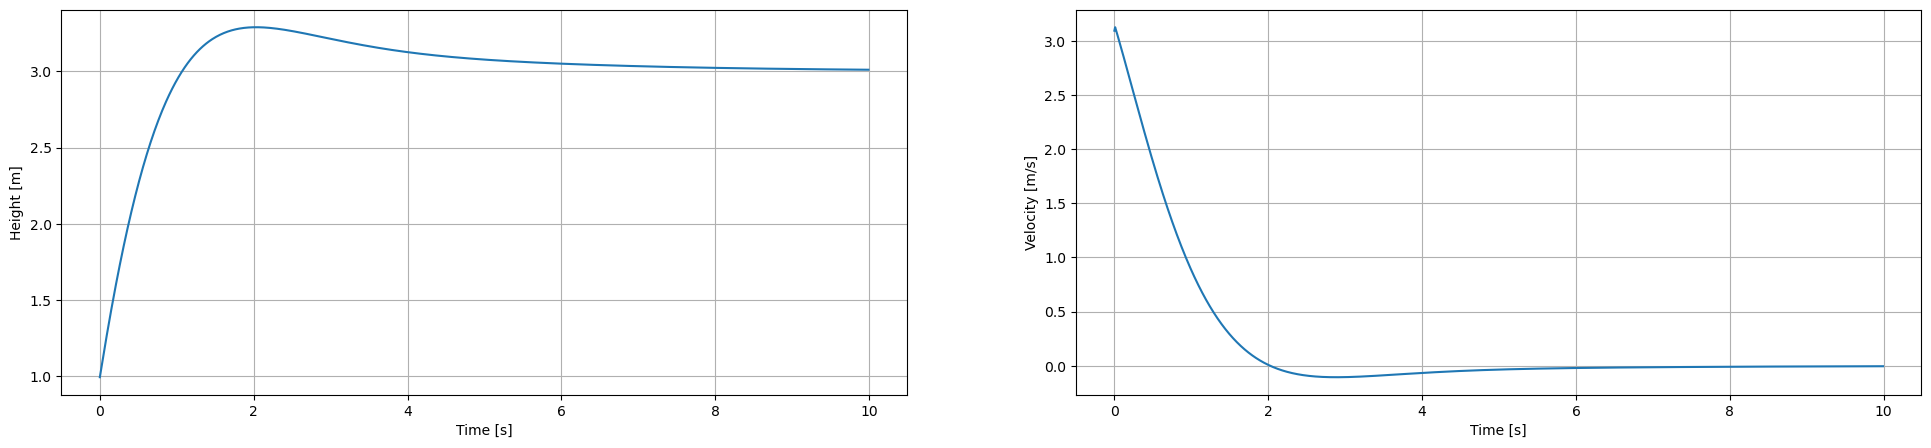

In [9]:
# Visualization

# part 3: motion
plt.figure(figsize=(24,5))
plt.subplot(121)
plt.plot(time[:-1], motion_t[0, :-1], label='x')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.grid()


plt.subplot(122)
plt.plot(time[:-1], motion_t[1, :-1], label='v')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid()

In [90]:
############################################################
'''
Part 2: RK4 Validation with rocket dynamic + PID control
'''

# Now we introduce the rocket dynamic here
############################################################

## parameter setup
# Integration parameter 
h=1/1000  # step size    (sec)
t0=0    # initial time (sec)
tf=10    # final time (sec)


time=np.linspace(t0,tf,int((tf-t0)/h))

## motion initial state
x_t0=0.0
v_t0=0
a_t0=0

x_target=4.5         # height target [m]

motion_t0=np.array([x_t0,v_t0])
motion_t=np.zeros((len(motion_t0),len(time)))

## mass
m_hop=3.5    # mass of hopper [kg]
m_hose=1     # mass of hose   [kg]
k_hose=6     # variable hopper mass [N/m]
F_RR=10      # rolling resistence [N]

## constant
R=8.314            # universal gas constant [J/kmol*K]
M=28.013           # nitrogen gas  [kg/kmol]
gamma=1.4          # ratio of specific heats (diatomic gas)
g=9.81             # [m/s^2]

## Nozzle
Th_d=9e-3                        # throat diameter [m]
Th_exit_d=11e-3                  # exit diameter [m]
A_throat=np.pi*(Th_d/2)**2      #[m^2]
A_e=np.pi*(Th_exit_d/2)**2      #[m^2]
epsilon=A_e/A_throat            #expansion ratio
T_4=273                         # nozzle inlet temperature [k]


## Mach number
Me=1.8486328125000004        # from the main file, no longer do iteration

## PID parameters (gain has to be larger since the step size is really small)
kp=45
ki=10
kd=33

integral=0   # initialize the integral
lasterr=0    # for the kd  

prev_pose=x_t0

In [91]:
# Butcher Array
RK4matrix=np.array([
      [0,0,0,0],
      [1/4,1/4,0,0],
      [27/40,-189/800,729/800,0],       
      [1,214/891,1/33,650/891],       
      [214/891,1/33,650/891,0],      
   ])


def rk4_ex(f,t,x,h,*args):  #*args allows unknown number of arguments
   k1=f(t+h*RK4matrix[0][0],x+h*RK4matrix[0][1],*args)
   k2=f(t+h*RK4matrix[1][0],x+h*k1*RK4matrix[1][1],*args)
   k3=f(t+h*RK4matrix[2][0],x+h*k2*RK4matrix[2][1],*args)
   k4=f(t+h*RK4matrix[3][0],x+h*k3*RK4matrix[3][1],*args)

   xnext=x+h*(k1*RK4matrix[4][0]+k2*RK4matrix[4][1]+k3*RK4matrix[4][2]+k4*RK4matrix[4][3])
   return xnext



def dx(t,motion,dotm,ve,prev_pose,*args):
   xdot=motion[1]
   xdotdot=dotm*ve/m_hop-g-F_RR/m_hop*np.sign(motion[1])-k_hose/m_hose*(motion[0]-prev_pose)   # the last term (hose) assumes that the hose become the damping term

   return np.array([xdot,xdotdot])

def PID(x,h,kp,ki,kd):
   global integral, lasterr
  
   err=x-x_target
   integral=integral+ki*err*h
   derr=(err-lasterr)/h
   
   lasterr=err

   PIDlaw=-(kp*err+kd*derr+ki*integral)
   print("error: ",err, "integral: ", integral, "derror: ",derr)

   if PIDlaw<1:
      output=1
   elif PIDlaw>11:
      output=11
   else:
      output=PIDlaw

   return output


def stateupdate(t,h,motion):
   global prev_pose
   
   x=motion[0]
   
   p4n=PID(x,h,kp,ki,kd)*1e5                                                       # control input (modify once deploy the controller)
   md4n=A_throat*p4n/(np.sqrt(T_4*R/(M*gamma)))*np.power((gamma+1)/2,-(gamma+1)/(2*(gamma-1)))

   # Nozzle exit
   pe=p4n/np.power(1+((gamma-1)/2*Me**2), gamma/(gamma-1))                         #exit pressure (use the assumption of p_4/p_ambient>1.8)
   ve=np.sqrt((2*gamma*R*T_4)/(gamma-1)/M*(1-np.power(pe/p4n,(gamma-1)/gamma)))    #exit velocity

   print("ve: ",ve,"pe: ",pe," p4: ",p4n)

   # update the motion
   motion_n=rk4_ex(dx,t,motion,h,md4n,ve,prev_pose)

   return motion_n

In [92]:
# Main iteration loop
motion_ti=motion_t0


for ti in range(len(time)):
    #
    t=time[ti]

    # calculte the new value (RK4/Algebraic update)
    motion_ti=stateupdate(t,h,motion_ti)

    #store the step
    motion_t[:,ti]=motion_ti
    
    prev_pose=motion_t[0,ti-1] if ti>0 else x_t0
   
    #print(f'Step {t} of {len(time)-1}'.format())


print("last position is", motion_t[0,-1])

error:  -4.5 integral:  -0.045 derror:  -4500.0
ve:  15.17455978805582 pe:  177687.55275170016  p4:  1100000.0
error:  -4.500001694053758 integral:  -0.09000001694053758 derror:  -0.001694053757717029
ve:  15.17455978805582 pe:  177687.55275170016  p4:  1100000.0
error:  -4.499988142331917 integral:  -0.13499989836385676 derror:  0.01355172184069886
ve:  15.17455978805582 pe:  177687.55275170016  p4:  1100000.0
error:  -4.499964178047634 integral:  -0.1799995401443331 derror:  0.023964284283195525
ve:  15.17455978805582 pe:  177687.55275170016  p4:  1100000.0
error:  -4.499929801286867 integral:  -0.22499883815720176 derror:  0.03437676076689655
ve:  15.17455978805582 pe:  177687.55275170016  p4:  1100000.0
error:  -4.499885012101797 integral:  -0.26999768827821974 derror:  0.04478918507011542
ve:  15.17455978805582 pe:  177687.55275170016  p4:  1100000.0
error:  -4.499829810544605 integral:  -0.31499598638366577 derror:  0.05520155719196396
ve:  15.17455978805582 pe:  177687.552751700

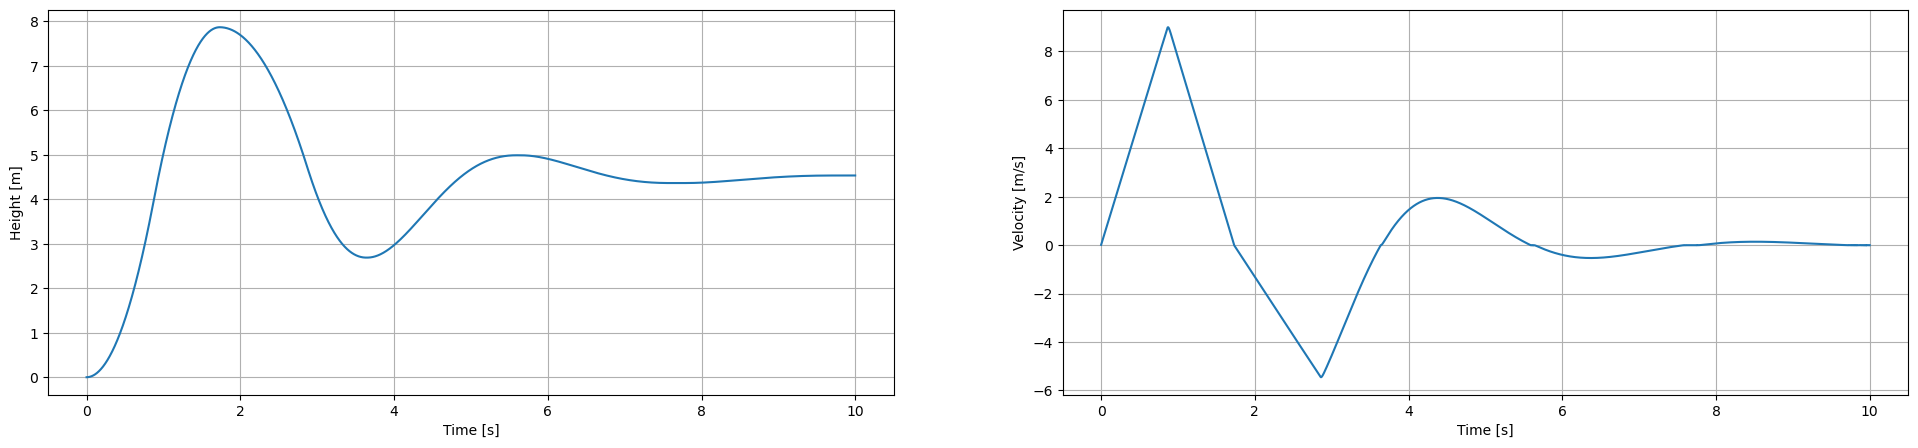

In [93]:
# Visualization

# part 3: motion
plt.figure(figsize=(24,5))
plt.subplot(121)
plt.plot(time[:-1], motion_t[0, :-1], label='x')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.grid()


plt.subplot(122)
plt.plot(time[:-1], motion_t[1, :-1], label='v')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid()

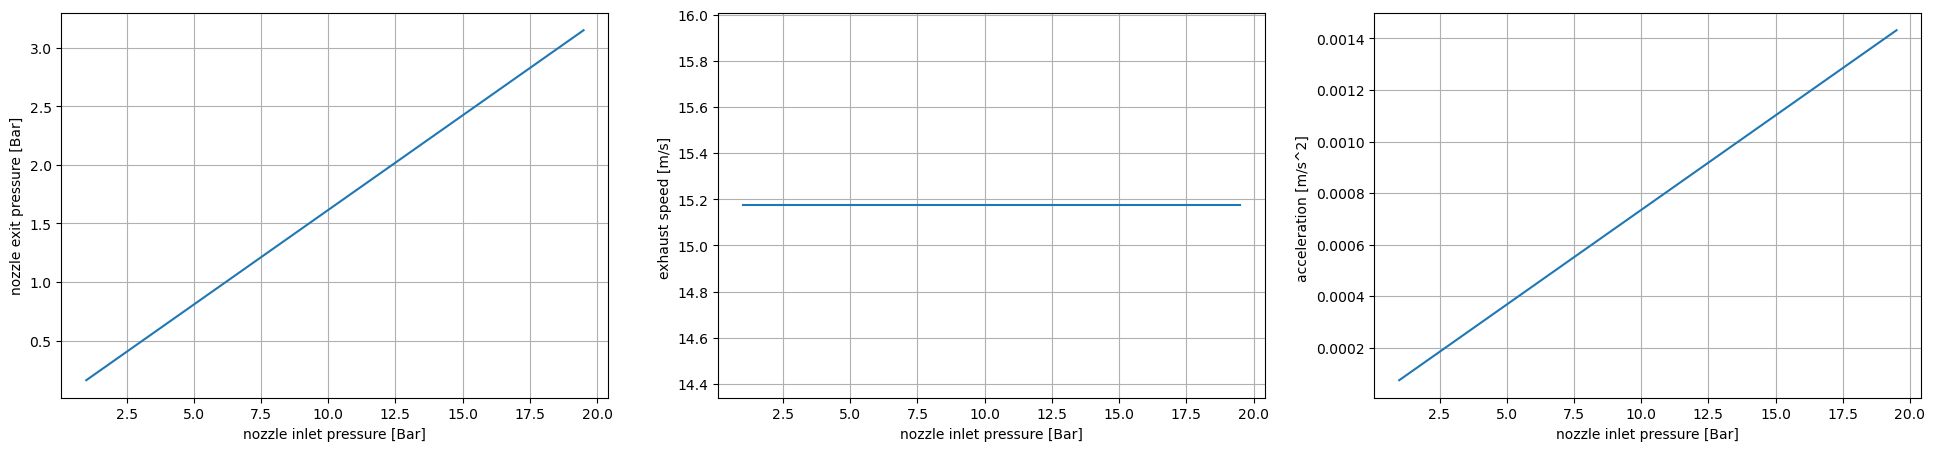

In [ ]:
############################################################
'''
Side Note: discuss the nozzle mass flow rate (chocked) (dot_m) / exhaust velocity (ve) respect to nozzle inlet pressure 
'''

# Now we introduce the rocket dynamic here
############################################################

p4n=np.arange(1,20,0.25)                                                   # assume 1-11 bar
md4n=A_throat*p4n/(np.sqrt(T_4*R/(M*gamma)))*np.power((gamma+1)/2,-(gamma+1)/(2*(gamma-1)))

# Nozzle exit
pe=p4n/np.power(1+((gamma-1)/2*Me**2), gamma/(gamma-1))                         #exit pressure (use the assumption of p_4/p_ambient>1.8)
ve=np.sqrt((2*gamma*R*T_4)/(gamma-1)/M*(1-np.power(pe/p4n,(gamma-1)/gamma)))    #exit velocity

acceleration=md4n*ve  # assume mass=1kg  -> linear relation 1

## Visualization 
plt.figure(figsize=(24,5))
plt.subplot(131)
plt.plot(p4n[:-1], pe[:-1], label='p')
plt.xlabel('nozzle inlet pressure [Bar]')
plt.ylabel('nozzle exit pressure [Bar]')
plt.grid()


plt.subplot(132)
plt.plot(p4n[:-1], ve[:-1])
plt.xlabel('nozzle inlet pressure [Bar]')
plt.ylabel('exhaust speed [m/s] ')
plt.grid()

plt.subplot(133)
plt.plot(p4n[:-1], acceleration[:-1])
plt.xlabel('nozzle inlet pressure [Bar]')
plt.ylabel('acceleration [m/s^2] ')
plt.grid()
plt.show()